In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import torch
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
import re
import calendar
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#%matplotlib inline


# Поменять на свой ник на lichess
player = 'waltalgg'

Код для парсинга pgn файла:


```python
import chess.pgn
import csv
with open('data.pgn', encoding='utf-8') as pgn_file:
    game = chess.pgn.read_game(pgn_file)
    with open('data.csv', 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        
        # Запись заголовков CSV файла
        csv_writer.writerow(['Event', 'Site', 'Date', 'UTCTime', 'White', 'Black', 'WhiteElo', 'BlackElo', 'Result'])

        while game is not None:
            headers = game.headers
            result = headers.get('Result', 'N/A')
            csv_writer.writerow([
                headers.get('Event', 'N/A'),
                headers.get('Site', 'N/A'),
                headers.get('Date', 'N/A'),
                headers.get('UTCTime', 'N/A'),
                headers.get('White', 'N/A'),
                headers.get('Black', 'N/A'),
                headers.get('WhiteElo', 'N/A'),
                headers.get('BlackElo', 'N/A'),
                result
            ])
            game = chess.pgn.read_game(pgn_file)
```

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22100 entries, 0 to 22099
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Event     22100 non-null  object
 1   Site      22100 non-null  object
 2   Date      22100 non-null  object
 3   UTCTime   22100 non-null  object
 4   White     22100 non-null  object
 5   Black     22100 non-null  object
 6   WhiteElo  22100 non-null  object
 7   BlackElo  22100 non-null  object
 8   Result    22100 non-null  object
dtypes: object(9)
memory usage: 1.5+ MB


In [4]:
df.isnull().sum()

Event       0
Site        0
Date        0
UTCTime     0
White       0
Black       0
WhiteElo    0
BlackElo    0
Result      0
dtype: int64

In [5]:
df

,Event,Site,Date,UTCTime,White,Black,WhiteElo,BlackElo,Result
0,Rated Blitz game,https://lichess.org/id1sNhOX,2024.03.04,15:18:35,waltalgg,ArtTikhon,1910,1897,1/2-1/2
1,Rated Blitz game,https://lichess.org/IzpSeMZD,2024.03.04,15:11:10,waltalgg,kingsajjad1,1917,1832,0-1
2,Rated Blitz game,https://lichess.org/yRhDDrf1,2024.03.04,15:05:54,maherrrrr,waltalgg,1932,1923,1-0
3,Rated Blitz game,https://lichess.org/TsegvnH9,2024.03.04,15:00:04,waltalgg,gurukhan,1928,1949,0-1
4,Rated Bullet game,https://lichess.org/veCY47ah,2024.03.04,12:22:38,RudraRaval1,waltalgg,2151,2196,1-0
...,...,...,...,...,...,...,...,...,...
22095,Rated Blitz game,https://lichess.org/kiE7SOnb,2019.02.03,13:33:16,waltalgg,Rico82,1190,1115,1-0
22096,Rated Blitz game,https://lichess.org/WLk8rrUW,2019.02.03,13:25:08,waltalgg,APAAP,1115,1136,1-0
22097,Rated Blitz game,https://lichess.org/BGYYzSVU,2019.02.03,11:38:06,Hmt135,waltalgg,1204,1201,1-0
22098,Rated Blitz game,https://lichess.org/HrgMR4XN,2019.02.03,11:31:40,elvasat,waltalgg,1310,1323,1-0


In [6]:
def determine_tournament_type(x):
    if re.search(r'\bRated\b', x):  # 'Rated' как отдельное слово
        return '0'
    return '1'

df['Tournament'] = df['Event'].apply(determine_tournament_type)

In [7]:
df['chess_clock'] = df['Event'].str.extract(r'(\b(?:Bullet|Blitz|Ultrabullet|Rapid)\b)', flags=re.IGNORECASE, expand=False)
df['chess_clock'] = df['chess_clock'].fillna('other')
df['chess_clock'] = df['chess_clock'].replace('BULLET', 'other')

In [8]:
def determine_time_of_day(time):
    hour = int(time.split(':')[0])
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

df['time_day'] = df['UTCTime'].apply(determine_time_of_day)

In [9]:
def determine_result(row):
    if player in row['White']:
        return row['Result'].split('-')[0]
    elif player in row['Black']:
        return row['Result'].split('-')[1]
    else:
        return None
    
def determine_result_opponent(row):
    if player in row['White']:
        return row['Result'].split('-')[1]
    elif player in row['Black']:
        return row['Result'].split('-')[0]
    else:
        return None
df['result_player'] = df.apply(determine_result, axis=1)
df['result_opponent'] = df.apply(determine_result_opponent, axis=1)

In [10]:
df['player_elo'] = ''
df['opponent_elo'] = ''

df.loc[df['White'] == player, 'player_elo'] = df['WhiteElo']
df.loc[df['Black'] == player, 'player_elo'] = df['BlackElo']

df.loc[df['White'] != player, 'opponent_elo'] = df['WhiteElo']
df.loc[df['Black'] != player, 'opponent_elo'] = df['BlackElo']


df = df[df['opponent_elo'] != '?']

In [11]:
df['month_game'] = pd.to_datetime(df['Date']).dt.month
df['year_game'] = pd.to_datetime(df['Date']).dt.year

df['month_game'] = df['month_game'].apply(lambda x: calendar.month_name[x])
df['year_game'] = df['year_game'].apply(lambda x: str(x))

C:\Users\walta\AppData\Local\Temp\ipykernel_16892\1883393780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_game'] = pd.to_datetime(df['Date']).dt.month
C:\Users\walta\AppData\Local\Temp\ipykernel_16892\1883393780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_game'] = pd.to_datetime(df['Date']).dt.year
C:\Users\walta\AppData\Local\Temp\ipykernel_16892\1883393780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [12]:
for col in ["Event", "White","Black", "Result", "Tournament", 'chess_clock', 'time_day', 'result_player']:
    print(df[col].value_counts(), end="\n\n")

Event
Rated Bullet game                        10497
Rated Blitz game                          5365
Hourly UltraBullet Arena                  1968
Rated Rapid game                           812
Daily UltraBullet Arena                    743
                                         ...  
Casual Rapid game                            1
Weekly King of the Hill Arena                1
Old Indian Defense Bullet Arena              1
Casual Antichess game                        1
CAREER, League of Legends Team Battle        1
Name: count, Length: 108, dtype: int64

White
waltalgg            11016
Oliverw-w              23
Nhyllz                 10
The_Rump                9
Nalchik_07              8
                    ...  
Karan_Trehan            1
VictorVV1               1
NationalistPride        1
vikharev                1
elvasat                 1
Name: count, Length: 9886, dtype: int64

Black
waltalgg           11055
Oliverw-w             18
The_Rump              13
archaeoadv            1

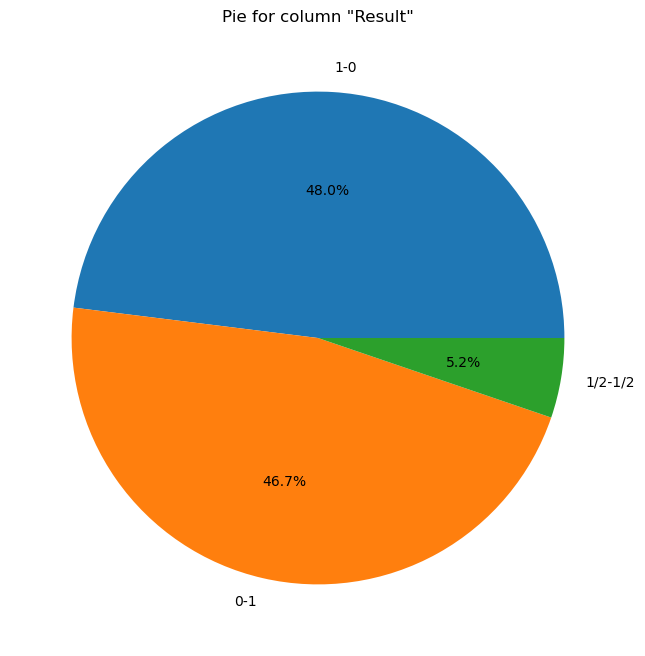

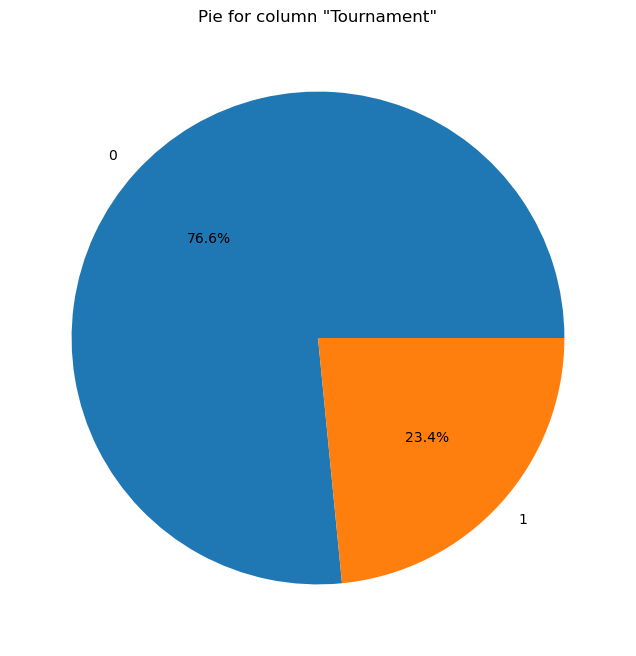

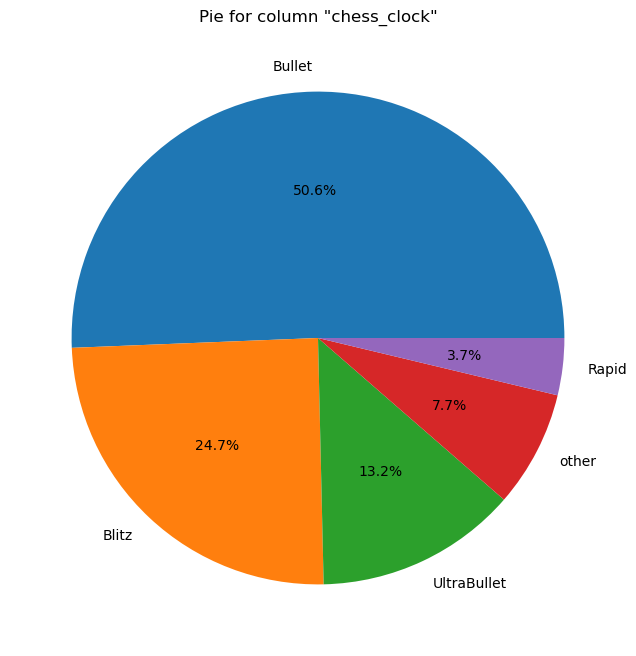

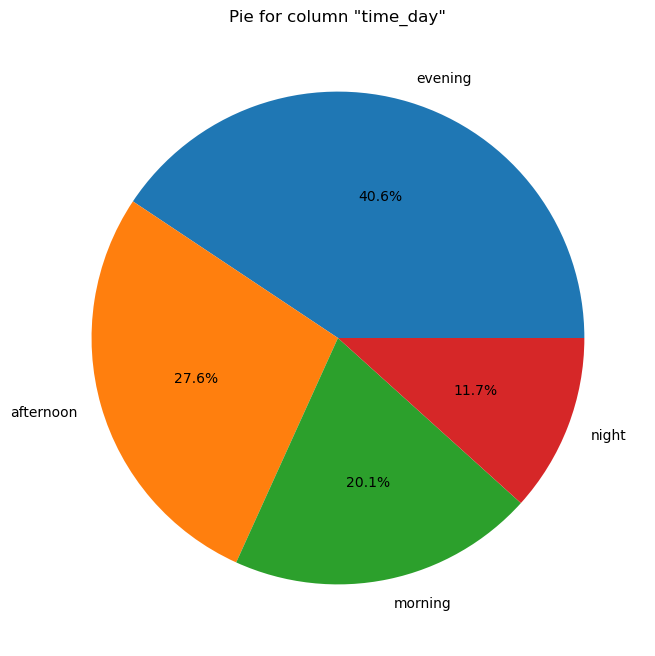

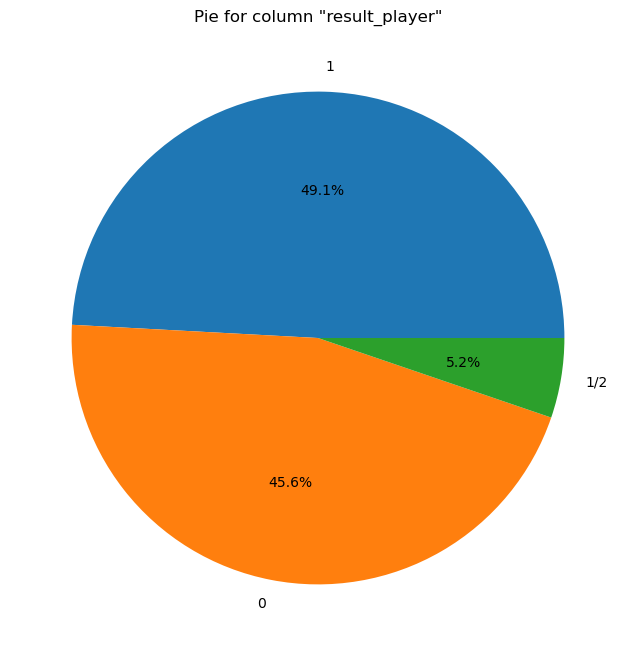

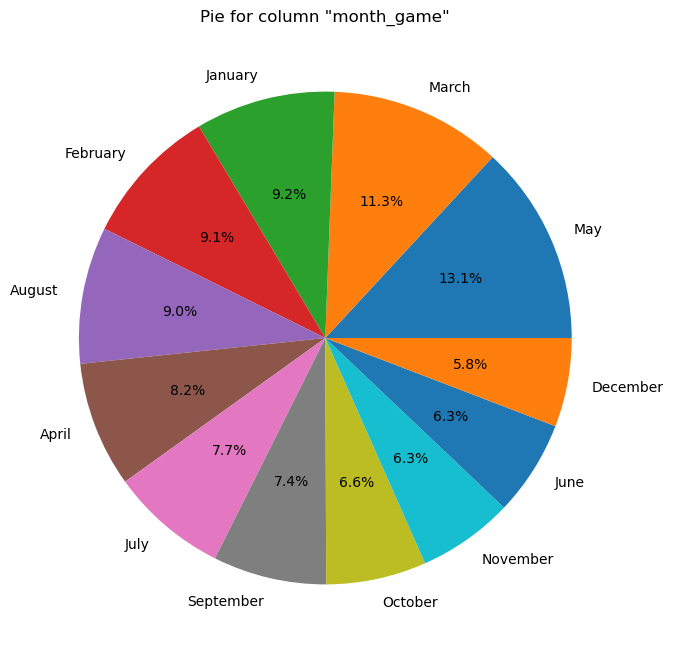

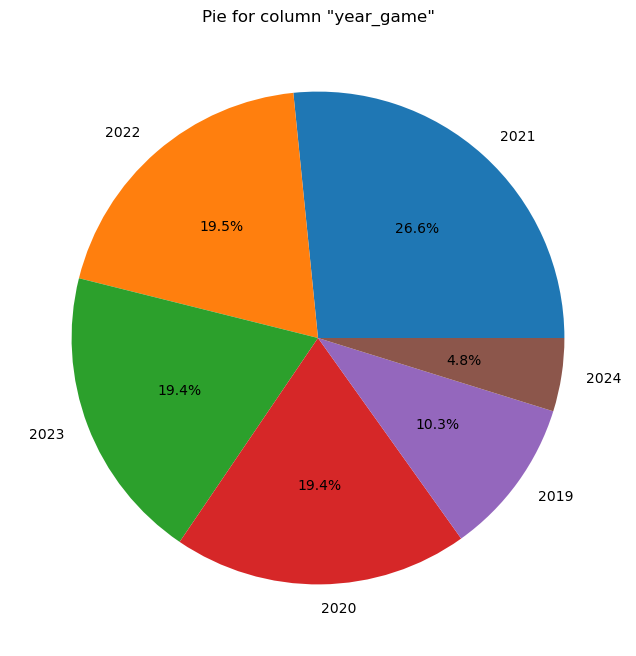

In [13]:
def pie(df, columns):
    for column in columns:
        value_counts = df[column].value_counts()    
        plt.figure(figsize=(8, 8))
        plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
        plt.title(f'Pie for column "{column}"')
        plt.show()
        
category_columns = ["Result", "Tournament", 'chess_clock', 'time_day', 'result_player', 'month_game', 'year_game']
pie(df, category_columns)

In [14]:
df

,Event,Site,Date,UTCTime,White,Black,WhiteElo,BlackElo,Result,Tournament,chess_clock,time_day,result_player,result_opponent,player_elo,opponent_elo,month_game,year_game
0,Rated Blitz game,https://lichess.org/id1sNhOX,2024.03.04,15:18:35,waltalgg,ArtTikhon,1910,1897,1/2-1/2,0,Blitz,afternoon,1/2,1/2,1910,1897,March,2024
1,Rated Blitz game,https://lichess.org/IzpSeMZD,2024.03.04,15:11:10,waltalgg,kingsajjad1,1917,1832,0-1,0,Blitz,afternoon,0,1,1917,1832,March,2024
2,Rated Blitz game,https://lichess.org/yRhDDrf1,2024.03.04,15:05:54,maherrrrr,waltalgg,1932,1923,1-0,0,Blitz,afternoon,0,1,1923,1932,March,2024
3,Rated Blitz game,https://lichess.org/TsegvnH9,2024.03.04,15:00:04,waltalgg,gurukhan,1928,1949,0-1,0,Blitz,afternoon,0,1,1928,1949,March,2024
4,Rated Bullet game,https://lichess.org/veCY47ah,2024.03.04,12:22:38,RudraRaval1,waltalgg,2151,2196,1-0,0,Bullet,afternoon,0,1,2196,2151,March,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22095,Rated Blitz game,https://lichess.org/kiE7SOnb,2019.02.03,13:33:16,waltalgg,Rico82,1190,1115,1-0,0,Blitz,afternoon,1,0,1190,1115,February,2019
22096,Rated Blitz game,https://lichess.org/WLk8rrUW,2019.02.03,13:25:08,waltalgg,APAAP,1115,1136,1-0,0,Blitz,afternoon,1,0,1115,1136,February,2019
22097,Rated Blitz game,https://lichess.org/BGYYzSVU,2019.02.03,11:38:06,Hmt135,waltalgg,1204,1201,1-0,0,Blitz,morning,0,1,1201,1204,February,2019
22098,Rated Blitz game,https://lichess.org/HrgMR4XN,2019.02.03,11:31:40,elvasat,waltalgg,1310,1323,1-0,0,Blitz,morning,0,1,1323,1310,February,2019


In [15]:
df.isnull().sum()

Event              0
Site               0
Date               0
UTCTime            0
White              0
Black              0
WhiteElo           0
BlackElo           0
Result             0
Tournament         0
chess_clock        0
time_day           0
result_player      0
result_opponent    0
player_elo         0
opponent_elo       0
month_game         0
year_game          0
dtype: int64

In [16]:
df.describe()

,Event,Site,Date,UTCTime,White,Black,WhiteElo,BlackElo,Result,Tournament,chess_clock,time_day,result_player,result_opponent,player_elo,opponent_elo,month_game,year_game
count,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071,22071
unique,108,22071,1535,18971,9886,9768,1242,1226,3,2,5,4,3,3,962,1374,12,6
top,Rated Bullet game,https://lichess.org/id1sNhOX,2021.05.27,20:06:49,waltalgg,waltalgg,2083,2084,1-0,0,Bullet,evening,1,0,2077,1500,May,2021
freq,10497,1,155,6,11016,11055,66,69,10601,16896,11176,8971,10847,10847,78,63,2896,5870


In [17]:
df = df[["Tournament", "chess_clock", "time_day", "result_player", "result_opponent", "player_elo", "opponent_elo", "month_game", "year_game"]]

In [18]:
df

,Tournament,chess_clock,time_day,result_player,result_opponent,player_elo,opponent_elo,month_game,year_game
0,0,Blitz,afternoon,1/2,1/2,1910,1897,March,2024
1,0,Blitz,afternoon,0,1,1917,1832,March,2024
2,0,Blitz,afternoon,0,1,1923,1932,March,2024
3,0,Blitz,afternoon,0,1,1928,1949,March,2024
4,0,Bullet,afternoon,0,1,2196,2151,March,2024
...,...,...,...,...,...,...,...,...,...
22095,0,Blitz,afternoon,1,0,1190,1115,February,2019
22096,0,Blitz,afternoon,1,0,1115,1136,February,2019
22097,0,Blitz,morning,0,1,1201,1204,February,2019
22098,0,Blitz,morning,0,1,1323,1310,February,2019
